# Ins

In [1]:
!pip install medmnist
!pip install albumentations
!pip install torchmetrics
!pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
#import matplotlib
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torchvision import models
# from torchmetrics.classification import BinaryF1Score
from medmnist import PneumoniaMNIST
print("Imported PneumoniaMNIST")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.6.0-py2.py3-none-any.whl size=117029 sha256=2ca9a69e1b8724e0b285cb56dd43f5281085365dffaa9ed30a7ddf75c6366230
  Stored in directory: /root/.cache/pip/wheels/d6/6d/5d/5b73fa0f46d01a793713f8859201361e9e581ced8c75e5c6a3
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.7 MB/s eta 0:00:0000:01
Imported PneumoniaMNIST


In [2]:
!rm -rf /kaggle/working/*

# MOCECT

## prep

In [3]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

from torchvision.transforms import v2
import torchvision.transforms.v2.functional as v2f
from torchvision.transforms import InterpolationMode

imgnet_mean = [0.485, 0.456, 0.406]
imgnet_std = [0.229, 0.224, 0.225]

train_transform = v2.Compose([
    # v2.RandomResizedCrop(224),
    v2.CenterCrop(224),
    v2.RandomHorizontalFlip(p = 0.5),
    v2.RandomVerticalFlip(p = 0.5),
#     v2.RandomRotation(degrees = 90),
    # v2.ToDtype(torch.float32, scale=True),
#     v2.RandomAffine(degrees = (0, 90), scale = (0.8, 0.9), shear = (-15, 15)),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale = True)]),
#     v2.GaussianNoise(mean = 0, sigma = 1e-7),
    v2.Normalize(imgnet_mean, imgnet_std)
])

empty_transform = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale = True)]),
    # v2.Grayscale(num_output_channels = 3),
    # v2.Normalize(imgnet_mean, imgnet_std)
])

val_test_transform = v2.Compose([
    # v2.Resize(256),
    v2.CenterCrop(224),
    # v2.ToDtype(torch.float32, scale=True),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale = True)]),
    v2.Normalize(imgnet_mean, imgnet_std)
])

d_trans = v2.Compose([
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale = True)]),
])

train_batch_size = 32
vt_batch_size = 32
num_workers = os.cpu_count()

# Datasets:
train_dataset = PneumoniaMNIST(
    split = "train",
    download = True,
    transform = train_transform,
    size = 224
)

val_dataset = PneumoniaMNIST(
    split = "val",
    download = True,
    transform = val_test_transform,
    size = 224
)

test_dataset = PneumoniaMNIST(
    split = "test",
    download = True,
    transform = val_test_transform,
    size = 224
)

dummy_set = PneumoniaMNIST(
    split = "train",
    download = True,
    size = 224,
    transform = d_trans
)

# Loaders:
train_loader = DataLoader(
    train_dataset,
    batch_size = train_batch_size,
    shuffle = True,
    num_workers = num_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size = vt_batch_size,
    shuffle = False,
    num_workers = num_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size = vt_batch_size,
    shuffle = False,
    num_workers = num_workers
)

print("Done prepping datasets")

100%|██████████| 214384716/214384716 [00:14<00:00, 14413477.81it/s]


Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist_224.npz
Done prepping datasets


## cbam + model + train

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:19<00:00, 5.38MB/s]



[1.93904448 0.67372639]



Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:13<00:00, 41.8MB/s] 
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 46.3MB/s]
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:02<00:00, 47.0MB/s] 
/opt/conda/lib/python3.10/site-packages/torch/nn/init.py:453: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


198236223 198236223 


Epoch 1/50 
------------------------------------------------------------


Training Epoch 1/50: 100%|██████████| 148/148 [01:02<00:00,  2.37batch/s, loss=0.25078, acc=0.79885, lr=[0.001]]


Train loss: 0.41463, acc: 0.79885, npv: 0.57572, ppv: 0.93243, sen: 0.78592, spe: 0.83608, f1: 0.85293


Validation Epoch 1/50: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, loss=0.19138, acc=0.86641]


Val loss: 0.24011, acc: 0.86641, npv: 0.67016, ppv: 0.97898, sen: 0.83805, spe: 0.94815, f1: 0.90305
New best epoch 1

Epoch 2/50 
------------------------------------------------------------


Training Epoch 2/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.25290, acc=0.87086, lr=[0.001]]


Train loss: 0.30085, acc: 0.87086, npv: 0.69373, ppv: 0.95897, sen: 0.86291, spe: 0.89374, f1: 0.90841


Validation Epoch 2/50: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, loss=0.12926, acc=0.90076]


Val loss: 0.22205, acc: 0.90076, npv: 0.74269, ppv: 0.97734, sen: 0.88689, spe: 0.94074, f1: 0.92992
New best epoch 2

Epoch 3/50 
------------------------------------------------------------


Training Epoch 3/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.35074, acc=0.89613, lr=[0.001]]


Train loss: 0.25365, acc: 0.89613, npv: 0.73864, ppv: 0.97115, sen: 0.88638, spe: 0.92422, f1: 0.92683


Validation Epoch 3/50: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, loss=0.11432, acc=0.89313]


Val loss: 0.20482, acc: 0.89313, npv: 0.72067, ppv: 0.98261, sen: 0.87147, spe: 0.95556, f1: 0.92371
New best epoch 3

Epoch 4/50 
------------------------------------------------------------


Training Epoch 4/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.43415, acc=0.89656, lr=[0.001]]


Train loss: 0.25321, acc: 0.89656, npv: 0.73743, ppv: 0.97325, sen: 0.88495, spe: 0.92998, f1: 0.92700


Validation Epoch 4/50: 100%|██████████| 17/17 [00:04<00:00,  4.01batch/s, loss=0.13214, acc=0.88740]


Val loss: 0.21120, acc: 0.88740, npv: 0.70213, ppv: 0.99107, sen: 0.85604, spe: 0.97778, f1: 0.91862

Epoch 5/50 
------------------------------------------------------------


Training Epoch 5/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00155, acc=0.91270, lr=[0.001]]


Train loss: 0.21465, acc: 0.91270, npv: 0.77183, ppv: 0.97710, sen: 0.90355, spe: 0.93904, f1: 0.93888


Validation Epoch 5/50: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, loss=0.10080, acc=0.90840]


Val loss: 0.18922, acc: 0.90840, npv: 0.75145, ppv: 0.98575, sen: 0.88946, spe: 0.96296, f1: 0.93514
New best epoch 5

Epoch 6/50 
------------------------------------------------------------


Training Epoch 6/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.47299, acc=0.91716, lr=[0.001]]


Train loss: 0.20747, acc: 0.91716, npv: 0.78414, ppv: 0.97637, sen: 0.91042, spe: 0.93657, f1: 0.94224


Validation Epoch 6/50: 100%|██████████| 17/17 [00:04<00:00,  4.01batch/s, loss=0.14487, acc=0.90458]


Val loss: 0.17616, acc: 0.90458, npv: 0.73743, ppv: 0.99130, sen: 0.87918, spe: 0.97778, f1: 0.93188
New best epoch 6

Epoch 7/50 
------------------------------------------------------------


Training Epoch 7/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.01544, acc=0.89953, lr=[0.001]]


Train loss: 0.23146, acc: 0.89953, npv: 0.74651, ppv: 0.97129, sen: 0.89096, spe: 0.92422, f1: 0.92939


Validation Epoch 7/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.10049, acc=0.92176]


Val loss: 0.15664, acc: 0.92176, npv: 0.79012, ppv: 0.98066, sen: 0.91260, spe: 0.94815, f1: 0.94541
New best epoch 7

Epoch 8/50 
------------------------------------------------------------


Training Epoch 8/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.09112, acc=0.91992, lr=[0.001]]


Train loss: 0.19332, acc: 0.91992, npv: 0.78882, ppv: 0.97821, sen: 0.91242, spe: 0.94152, f1: 0.94417


Validation Epoch 8/50: 100%|██████████| 17/17 [00:04<00:00,  4.01batch/s, loss=0.20285, acc=0.91031]


Val loss: 0.19281, acc: 0.91031, npv: 0.74719, ppv: 0.99422, sen: 0.88432, spe: 0.98519, f1: 0.93605

Epoch 9/50 
------------------------------------------------------------


Training Epoch 9/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.07150, acc=0.92927, lr=[0.001]]


Train loss: 0.17826, acc: 0.92927, npv: 0.81263, ppv: 0.97908, sen: 0.92444, spe: 0.94316, f1: 0.95098


Validation Epoch 9/50: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, loss=0.13817, acc=0.94275]


Val loss: 0.13973, acc: 0.94275, npv: 0.84768, ppv: 0.98123, sen: 0.94087, spe: 0.94815, f1: 0.96063
New best epoch 9

Epoch 10/50 
------------------------------------------------------------


Training Epoch 10/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.13844, acc=0.92715, lr=[0.001]]


Train loss: 0.17086, acc: 0.92715, npv: 0.80777, ppv: 0.97844, sen: 0.92215, spe: 0.94152, f1: 0.94946


Validation Epoch 10/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.08992, acc=0.94275]


Val loss: 0.12950, acc: 0.94275, npv: 0.83871, ppv: 0.98645, sen: 0.93573, spe: 0.96296, f1: 0.96042
New best epoch 10

Epoch 11/50 
------------------------------------------------------------


Training Epoch 11/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.01145, acc=0.93373, lr=[0.001]]


Train loss: 0.15953, acc: 0.93373, npv: 0.82214, ppv: 0.98096, sen: 0.92873, spe: 0.94811, f1: 0.95413


Validation Epoch 11/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.17946, acc=0.91221]


Val loss: 0.17646, acc: 0.91221, npv: 0.74860, ppv: 0.99710, sen: 0.88432, spe: 0.99259, f1: 0.93733

Epoch 12/50 
------------------------------------------------------------


Training Epoch 12/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.01385, acc=0.94116, lr=[0.001]]


Train loss: 0.14118, acc: 0.94116, npv: 0.83974, ppv: 0.98318, sen: 0.93675, spe: 0.95387, f1: 0.95940


Validation Epoch 12/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.08425, acc=0.93702]


Val loss: 0.11802, acc: 0.93702, npv: 0.81098, ppv: 0.99444, sen: 0.92031, spe: 0.98519, f1: 0.95594
New best epoch 12

Epoch 13/50 
------------------------------------------------------------


Training Epoch 13/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00491, acc=0.94371, lr=[0.001]]


Train loss: 0.14432, acc: 0.94371, npv: 0.84711, ppv: 0.98324, sen: 0.94018, spe: 0.95387, f1: 0.96123


Validation Epoch 13/50: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, loss=0.07953, acc=0.95229]


Val loss: 0.10578, acc: 0.95229, npv: 0.86667, ppv: 0.98663, sen: 0.94859, spe: 0.96296, f1: 0.96723
New best epoch 13

Epoch 14/50 
------------------------------------------------------------


Training Epoch 14/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.24158, acc=0.94860, lr=[0.001]]


Train loss: 0.12863, acc: 0.94860, npv: 0.85788, ppv: 0.98537, sen: 0.94476, spe: 0.95964, f1: 0.96464


Validation Epoch 14/50: 100%|██████████| 17/17 [00:04<00:00,  4.01batch/s, loss=0.17668, acc=0.89885]


Val loss: 0.18532, acc: 0.89885, npv: 0.71809, ppv: 1.00000, sen: 0.86375, spe: 1.00000, f1: 0.92690

Epoch 15/50 
------------------------------------------------------------


Training Epoch 15/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.13590, acc=0.94584, lr=[0.001]]


Train loss: 0.13827, acc: 0.94584, npv: 0.85077, ppv: 0.98474, sen: 0.94161, spe: 0.95799, f1: 0.96269


Validation Epoch 15/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.10385, acc=0.91985]


Val loss: 0.13816, acc: 0.91985, npv: 0.76271, ppv: 1.00000, sen: 0.89203, spe: 1.00000, f1: 0.94293

Epoch 16/50 
------------------------------------------------------------


Training Epoch 16/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.05794, acc=0.94945, lr=[0.001]]


Train loss: 0.12571, acc: 0.94945, npv: 0.85988, ppv: 0.98568, sen: 0.94562, spe: 0.96046, f1: 0.96524


Validation Epoch 16/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.06462, acc=0.93511]


Val loss: 0.10459, acc: 0.93511, npv: 0.80240, ppv: 0.99720, sen: 0.91517, spe: 0.99259, f1: 0.95442
New best epoch 16

Epoch 17/50 
------------------------------------------------------------


Training Epoch 17/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00397, acc=0.95221, lr=[0.001]]


Train loss: 0.11812, acc: 0.95221, npv: 0.86494, ppv: 0.98747, sen: 0.94762, spe: 0.96540, f1: 0.96714


Validation Epoch 17/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.07731, acc=0.95802]


Val loss: 0.08382, acc: 0.95802, npv: 0.86452, ppv: 0.99729, sen: 0.94602, spe: 0.99259, f1: 0.97098
New best epoch 17

Epoch 18/50 
------------------------------------------------------------


Training Epoch 18/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00099, acc=0.94966, lr=[0.001]]


Train loss: 0.12452, acc: 0.94966, npv: 0.86105, ppv: 0.98539, sen: 0.94619, spe: 0.95964, f1: 0.96540


Validation Epoch 18/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.08147, acc=0.95992]


Val loss: 0.08892, acc: 0.95992, npv: 0.87500, ppv: 0.99462, sen: 0.95116, spe: 0.98519, f1: 0.97240

Epoch 19/50 
------------------------------------------------------------


Training Epoch 19/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.15098, acc=0.95178, lr=[0.001]]


Train loss: 0.12159, acc: 0.95178, npv: 0.86313, ppv: 0.98776, sen: 0.94677, spe: 0.96623, f1: 0.96683


Validation Epoch 19/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.04302, acc=0.97137]


Val loss: 0.08174, acc: 0.97137, npv: 0.92254, ppv: 0.98953, sen: 0.97172, spe: 0.97037, f1: 0.98054
New best epoch 19

Epoch 20/50 
------------------------------------------------------------


Training Epoch 20/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.20721, acc=0.95688, lr=[0.001]]


Train loss: 0.11069, acc: 0.95688, npv: 0.87809, ppv: 0.98813, sen: 0.95335, spe: 0.96705, f1: 0.97043


Validation Epoch 20/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.12972, acc=0.93130]


Val loss: 0.11789, acc: 0.93130, npv: 0.78947, ppv: 1.00000, sen: 0.90746, spe: 1.00000, f1: 0.95148

Epoch 21/50 
------------------------------------------------------------


Training Epoch 21/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.24383, acc=0.95455, lr=[0.001]]


Train loss: 0.10848, acc: 0.95455, npv: 0.87258, ppv: 0.98723, sen: 0.95106, spe: 0.96458, f1: 0.96880


Validation Epoch 21/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.14699, acc=0.91794]


Val loss: 0.13611, acc: 0.91794, npv: 0.75843, ppv: 1.00000, sen: 0.88946, spe: 1.00000, f1: 0.94150

Epoch 22/50 
------------------------------------------------------------


Training Epoch 22/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.01527, acc=0.95051, lr=[0.001]]


Train loss: 0.12065, acc: 0.95051, npv: 0.86253, ppv: 0.98599, sen: 0.94677, spe: 0.96129, f1: 0.96598


Validation Epoch 22/50: 100%|██████████| 17/17 [00:04<00:00,  4.01batch/s, loss=0.08359, acc=0.92557]


Val loss: 0.13443, acc: 0.92557, npv: 0.77586, ppv: 1.00000, sen: 0.89974, spe: 1.00000, f1: 0.94723

Epoch 23/50 
------------------------------------------------------------


Training Epoch 23/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.29328, acc=0.96177, lr=[0.001]]


Train loss: 0.09891, acc: 0.96177, npv: 0.89526, ppv: 0.98735, sen: 0.96079, spe: 0.96458, f1: 0.97389


Validation Epoch 23/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.03716, acc=0.97328]


Val loss: 0.07647, acc: 0.97328, npv: 0.91724, ppv: 0.99472, sen: 0.96915, spe: 0.98519, f1: 0.98177
New best epoch 23

Epoch 24/50 
------------------------------------------------------------


Training Epoch 24/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.03093, acc=0.95667, lr=[0.001]]


Train loss: 0.10629, acc: 0.95667, npv: 0.88142, ppv: 0.98611, sen: 0.95507, spe: 0.96129, f1: 0.97034


Validation Epoch 24/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.05587, acc=0.96947]


Val loss: 0.07523, acc: 0.96947, npv: 0.89404, ppv: 1.00000, sen: 0.95887, spe: 1.00000, f1: 0.97900
New best epoch 24

Epoch 25/50 
------------------------------------------------------------


Training Epoch 25/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.20099, acc=0.96240, lr=[0.001]]


Train loss: 0.09438, acc: 0.96240, npv: 0.89610, ppv: 0.98794, sen: 0.96108, spe: 0.96623, f1: 0.97432


Validation Epoch 25/50: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, loss=0.03541, acc=0.94466]


Val loss: 0.10896, acc: 0.94466, npv: 0.82317, ppv: 1.00000, sen: 0.92545, spe: 1.00000, f1: 0.96128

Epoch 26/50 
------------------------------------------------------------


Training Epoch 26/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.01377, acc=0.96092, lr=[0.001]]


Train loss: 0.09750, acc: 0.96092, npv: 0.88780, ppv: 0.98964, sen: 0.95736, spe: 0.97117, f1: 0.97323


Validation Epoch 26/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.15991, acc=0.89122]


Val loss: 0.16915, acc: 0.89122, npv: 0.70312, ppv: 1.00000, sen: 0.85347, spe: 1.00000, f1: 0.92094

Epoch 27/50 
------------------------------------------------------------


Training Epoch 27/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.25050, acc=0.96304, lr=[0.001]]


Train loss: 0.09340, acc: 0.96304, npv: 0.89755, ppv: 0.98824, sen: 0.96165, spe: 0.96705, f1: 0.97476


Validation Epoch 27/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.06476, acc=0.95802]


Val loss: 0.06423, acc: 0.95802, npv: 0.85987, ppv: 1.00000, sen: 0.94344, spe: 1.00000, f1: 0.97090
New best epoch 27

Epoch 28/50 
------------------------------------------------------------


Training Epoch 28/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00180, acc=0.95986, lr=[0.001]]


Train loss: 0.09568, acc: 0.95986, npv: 0.89033, ppv: 0.98675, sen: 0.95879, spe: 0.96293, f1: 0.97256


Validation Epoch 28/50: 100%|██████████| 17/17 [00:04<00:00,  4.06batch/s, loss=0.04675, acc=0.95611]


Val loss: 0.09218, acc: 0.95611, npv: 0.85443, ppv: 1.00000, sen: 0.94087, spe: 1.00000, f1: 0.96954

Epoch 29/50 
------------------------------------------------------------


Training Epoch 29/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00581, acc=0.96517, lr=[0.001]]


Train loss: 0.08807, acc: 0.96517, npv: 0.89954, ppv: 0.99057, sen: 0.96222, spe: 0.97364, f1: 0.97619


Validation Epoch 29/50: 100%|██████████| 17/17 [00:04<00:00,  4.07batch/s, loss=0.02107, acc=0.95420]


Val loss: 0.08424, acc: 0.95420, npv: 0.84906, ppv: 1.00000, sen: 0.93830, spe: 1.00000, f1: 0.96817

Epoch 30/50 
------------------------------------------------------------


Training Epoch 30/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00033, acc=0.96432, lr=[0.001]]


Train loss: 0.08861, acc: 0.96432, npv: 0.89742, ppv: 0.99027, sen: 0.96136, spe: 0.97282, f1: 0.97560


Validation Epoch 30/50: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, loss=0.04185, acc=0.97519]


Val loss: 0.08933, acc: 0.97519, npv: 0.94853, ppv: 0.98454, sen: 0.98201, spe: 0.95556, f1: 0.98327

Epoch 31/50 
------------------------------------------------------------


Training Epoch 31/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00087, acc=0.97345, lr=[0.001]]


Train loss: 0.07149, acc: 0.97345, npv: 0.92046, ppv: 0.99355, sen: 0.97052, spe: 0.98188, f1: 0.98190


Validation Epoch 31/50: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, loss=0.03089, acc=0.97710]


Val loss: 0.06641, acc: 0.97710, npv: 0.94891, ppv: 0.98708, sen: 0.98201, spe: 0.96296, f1: 0.98454

Epoch 32/50 
------------------------------------------------------------


Training Epoch 32/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.17073, acc=0.96771, lr=[0.001]]


Train loss: 0.08658, acc: 0.96771, npv: 0.90846, ppv: 0.99032, sen: 0.96594, spe: 0.97282, f1: 0.97798


Validation Epoch 32/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.01925, acc=0.97328]


Val loss: 0.07045, acc: 0.97328, npv: 0.91156, ppv: 0.99735, sen: 0.96658, spe: 0.99259, f1: 0.98172

Epoch 33/50 
------------------------------------------------------------


Training Epoch 33/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.50945, acc=0.95773, lr=[0.001]]


Train loss: 0.10081, acc: 0.95773, npv: 0.88187, ppv: 0.98757, sen: 0.95507, spe: 0.96540, f1: 0.97105


Validation Epoch 33/50: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, loss=0.01195, acc=0.97328]


Val loss: 0.06492, acc: 0.97328, npv: 0.91156, ppv: 0.99735, sen: 0.96658, spe: 0.99259, f1: 0.98172

Epoch 34/50 
------------------------------------------------------------


Training Epoch 34/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.03621, acc=0.96580, lr=[0.0005]]


Train loss: 0.08498, acc: 0.96580, npv: 0.89977, ppv: 0.99145, sen: 0.96222, spe: 0.97611, f1: 0.97662


Validation Epoch 34/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.02317, acc=0.97710]


Val loss: 0.05099, acc: 0.97710, npv: 0.93007, ppv: 0.99475, sen: 0.97429, spe: 0.98519, f1: 0.98442
New best epoch 34

Epoch 35/50 
------------------------------------------------------------


Training Epoch 35/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.03129, acc=0.96984, lr=[0.0005]]


Train loss: 0.07030, acc: 0.96984, npv: 0.91422, ppv: 0.99092, sen: 0.96823, spe: 0.97446, f1: 0.97944


Validation Epoch 35/50: 100%|██████████| 17/17 [00:04<00:00,  4.04batch/s, loss=0.01238, acc=0.97710]


Val loss: 0.06218, acc: 0.97710, npv: 0.91837, ppv: 1.00000, sen: 0.96915, spe: 1.00000, f1: 0.98433

Epoch 36/50 
------------------------------------------------------------


Training Epoch 36/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.20348, acc=0.97026, lr=[0.0005]]


Train loss: 0.07141, acc: 0.97026, npv: 0.91499, ppv: 0.99121, sen: 0.96852, spe: 0.97529, f1: 0.97973


Validation Epoch 36/50: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, loss=0.03776, acc=0.98092]


Val loss: 0.05793, acc: 0.98092, npv: 0.94964, ppv: 0.99221, sen: 0.98201, spe: 0.97778, f1: 0.98708

Epoch 37/50 
------------------------------------------------------------


Training Epoch 37/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.02521, acc=0.97048, lr=[0.0005]]


Train loss: 0.07200, acc: 0.97048, npv: 0.91442, ppv: 0.99179, sen: 0.96823, spe: 0.97694, f1: 0.97987


Validation Epoch 37/50: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, loss=0.03176, acc=0.98092]


Val loss: 0.05948, acc: 0.98092, npv: 0.94326, ppv: 0.99478, sen: 0.97943, spe: 0.98519, f1: 0.98705

Epoch 38/50 
------------------------------------------------------------


Training Epoch 38/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00253, acc=0.97472, lr=[0.0005]]


Train loss: 0.06658, acc: 0.97472, npv: 0.92409, ppv: 0.99385, sen: 0.97195, spe: 0.98270, f1: 0.98278


Validation Epoch 38/50: 100%|██████████| 17/17 [00:04<00:00,  4.05batch/s, loss=0.01681, acc=0.97710]


Val loss: 0.05388, acc: 0.97710, npv: 0.91837, ppv: 1.00000, sen: 0.96915, spe: 1.00000, f1: 0.98433

Epoch 39/50 
------------------------------------------------------------


Training Epoch 39/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00021, acc=0.97260, lr=[0.0005]]


Train loss: 0.06678, acc: 0.97260, npv: 0.92350, ppv: 0.99095, sen: 0.97195, spe: 0.97446, f1: 0.98136


Validation Epoch 39/50: 100%|██████████| 17/17 [00:04<00:00,  4.01batch/s, loss=0.02366, acc=0.97710]


Val loss: 0.05612, acc: 0.97710, npv: 0.92414, ppv: 0.99736, sen: 0.97172, spe: 0.99259, f1: 0.98437

Epoch 40/50 
------------------------------------------------------------


Training Epoch 40/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.01330, acc=0.97494, lr=[0.0005]]


Train loss: 0.06140, acc: 0.97494, npv: 0.92284, ppv: 0.99472, sen: 0.97138, spe: 0.98517, f1: 0.98291


Validation Epoch 40/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.03015, acc=0.97328]


Val loss: 0.05820, acc: 0.97328, npv: 0.90604, ppv: 1.00000, sen: 0.96401, spe: 1.00000, f1: 0.98168

Epoch 41/50 
------------------------------------------------------------


Training Epoch 41/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00010, acc=0.97727, lr=[0.00025]]


Train loss: 0.05612, acc: 0.97727, npv: 0.92940, ppv: 0.99532, sen: 0.97396, spe: 0.98682, f1: 0.98452


Validation Epoch 41/50: 100%|██████████| 17/17 [00:04<00:00,  3.99batch/s, loss=0.01961, acc=0.98282]


Val loss: 0.05382, acc: 0.98282, npv: 0.94366, ppv: 0.99738, sen: 0.97943, spe: 0.99259, f1: 0.98833

Epoch 42/50 
------------------------------------------------------------


Training Epoch 42/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.02384, acc=0.97770, lr=[0.00025]]


Train loss: 0.05363, acc: 0.97770, npv: 0.93422, ppv: 0.99388, sen: 0.97596, spe: 0.98270, f1: 0.98484


Validation Epoch 42/50: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, loss=0.01244, acc=0.98092]


Val loss: 0.05412, acc: 0.98092, npv: 0.93103, ppv: 1.00000, sen: 0.97429, spe: 1.00000, f1: 0.98698

Epoch 43/50 
------------------------------------------------------------


Training Epoch 43/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.00470, acc=0.97791, lr=[0.00025]]


Train loss: 0.05865, acc: 0.97791, npv: 0.93427, ppv: 0.99417, sen: 0.97596, spe: 0.98353, f1: 0.98498


Validation Epoch 43/50: 100%|██████████| 17/17 [00:04<00:00,  4.02batch/s, loss=0.01730, acc=0.96947]


Val loss: 0.06340, acc: 0.96947, npv: 0.89404, ppv: 1.00000, sen: 0.95887, spe: 1.00000, f1: 0.97900

Epoch 44/50 
------------------------------------------------------------


Training Epoch 44/50: 100%|██████████| 148/148 [01:00<00:00,  2.43batch/s, loss=0.99972, acc=0.98237, lr=[0.00025]]


Train loss: 0.04790, acc: 0.98237, npv: 0.94353, ppv: 0.99680, sen: 0.97939, spe: 0.99094, f1: 0.98802


Validation Epoch 44/50: 100%|██████████| 17/17 [00:04<00:00,  4.03batch/s, loss=0.01300, acc=0.95992]


Val loss: 0.07541, acc: 0.95992, npv: 0.86538, ppv: 1.00000, sen: 0.94602, spe: 1.00000, f1: 0.97226
Early stopping at epoch 44
Model saved at /kaggle/working/early_stop_model_epoch_44.pth


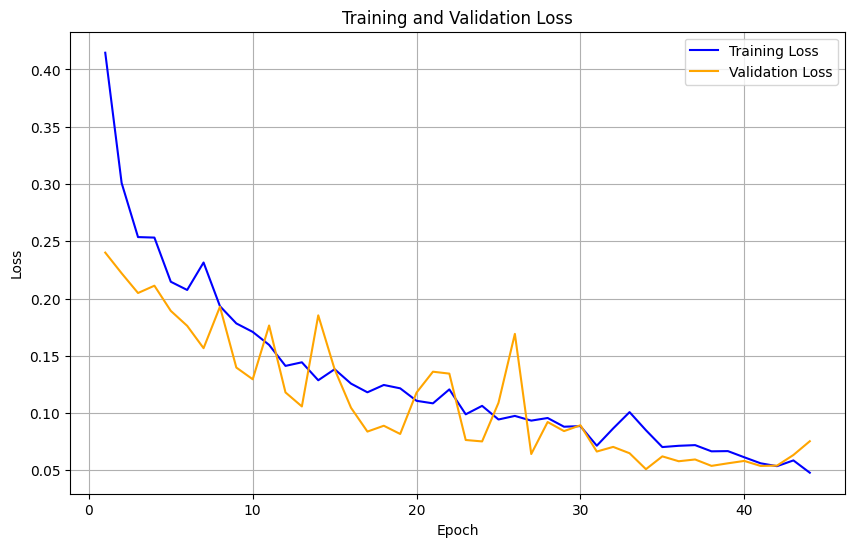

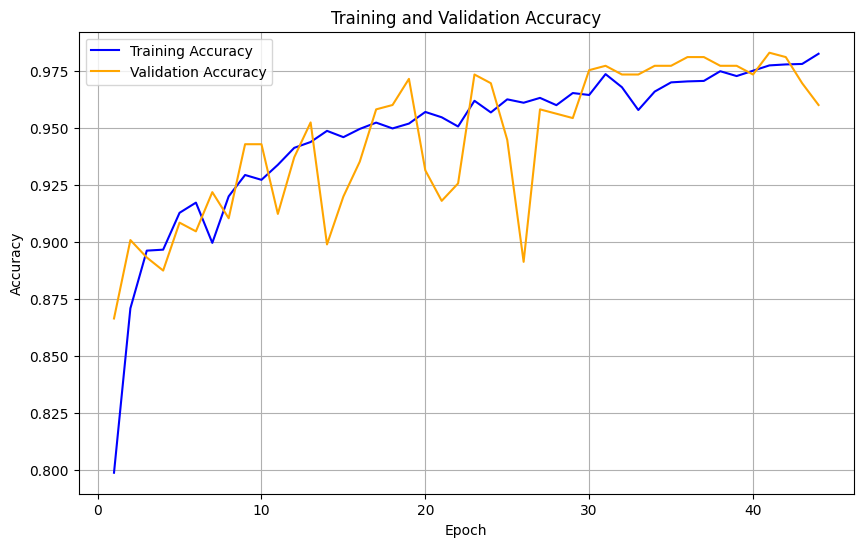

In [4]:
import torch
from torchvision.models.feature_extraction import create_feature_extractor
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

# Source: https://github.com/Jongchan/attention-module/blob/master/MODELS/cbam.py
import torch
import math
import torch.nn as nn
import torch.nn.functional as F

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

##EWCAVIT

class ResNet(torch.nn.Module):
    def __init__(self, useCBAM = False):
        super(ResNet, self).__init__()
        self.model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2')
        self.features = torch.nn.Sequential(*list(self.model.children())[:5])
        self.cbam = CBAM(256)
        self.useCBAM = useCBAM
        self.deconv = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            torch.nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        for name, param in self.features.named_parameters():
            param.requires_grad = False
        x = self.features(x)
        if self.useCBAM:
          x_cbam = self.cbam(x)
          x_out = self.deconv(x_cbam)
        else:
          x_out = self.deconv(x)
        return x_out

resnet = ResNet()

class VGGNet(torch.nn.Module):
    def __init__(self, useCBAM = False):
        super(VGGNet, self).__init__()
        self.model = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')
        self.features = torch.nn.Sequential(*list(self.model.features.children())[:17])
        self.cbam = CBAM(256)
        self.useCBAM = useCBAM
        self.deconv = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2, mode='bilinear'),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),
            torch.nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),
            torch.nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        for name, param in self.features.named_parameters():
            param.requires_grad = False
        x = self.features(x)
        if self.useCBAM:
          x_cbam = self.cbam(x)
          x_out = self.deconv(x_cbam)
        else:
          x_out = self.deconv(x)
        return x_out


class MobileNet(torch.nn.Module):
    def __init__(self, useCBAM = False):
        super(MobileNet, self).__init__()
        self.model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.IMAGENET1K_V1')
        self.features = torch.nn.Sequential(*list(self.model.features.children())[:2])
        self.cbam = CBAM(16)
        self.useCBAM = useCBAM
        self.deconv = torch.nn.Sequential(
            nn.Dropout2d(0.5),
            torch.nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x):
        for name, param in self.features.named_parameters():
            param.requires_grad = False
        x = self.features(x)
        if self.useCBAM:
          x_cbam = self.cbam(x)
          x_out = self.deconv(x_cbam)
        else:
          x_out = self.deconv(x)
        return x_out

# class DenseNet(torch.nn.Module):
#     def __init__(self, useCBAM = False):
#         super(DenseNet, self).__init__()
#         self.model = models.densenet161(weights='DenseNet161_Weights.IMAGENET1K_V1')
#         self.base = nn.Sequential(*list(self.model.features.children())[:5])
#         self.trans = nn.Sequential(*[list(self.model.features.children())[:6][5][0],
#                                      list(self.model.features.children())[:6][5][1],
#                                      list(self.model.features.children())[:6][5][2]])
#         self.features = nn.Sequential(self.base, self.trans)  # [192 x 56 x 56]
#         self.cbam = CBAM(192)
#         self.useCBAM = useCBAM
#         self.deconv = nn.Sequential(
#             # nn.BatchNorm2d(192),
#             # nn.ReLU(),
#             nn.ConvTranspose2d(192, 64, kernel_size=4, stride=2, padding=1),
#             # nn.BatchNorm2d(64),
#             nn.ReLU(inplace = True),
#             nn.Dropout2d(0.5),  # Dropout in deconv block
#             nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
#         )
#     def forward(self, x):
#         for name, param in self.features.named_parameters():
#             param.requires_grad = False
#         x = self.features(x)
#         if self.useCBAM:
#           x_attn = self.cbam(x)
#           x_out = self.deconv(x_attn)
#         else:
#           x_out = self.deconv(x)
#         return x_out


class SwinTransformer(torch.nn.Module):
    def __init__(self):
        super(SwinTransformer, self).__init__()
        self.backbone = models.swin_t(weights='Swin_T_Weights.IMAGENET1K_V1')
        self.features = create_feature_extractor(self.backbone, return_nodes=['flatten'])

    def forward(self, x):
        for name, param in self.features.named_parameters():
            param.requires_grad = False
        return self.features(x)


class Head(torch.nn.Module):
    def __init__(self):
        super(Head, self).__init__()
        self.mlp_head = torch.nn.Sequential(
            torch.nn.Linear(768, 2),
        )

    def forward(self, x):
        return self.mlp_head(x)


class EWCAT(torch.nn.Module):
    def __init__(self):
        super(EWCAT, self).__init__()
        self.vggnet = VGGNet(useCBAM = False)
        self.resnet = ResNet(useCBAM = False)
        self.mobilenet = MobileNet(useCBAM = False)
        # self.dense = DenseNet(useCBAM = False)
        self.swin_transformer = SwinTransformer()
        self.head = Head()
        self.cbam = CBAM(3)
        self.bn = torch.nn.BatchNorm2d(3)

    def forward(self, x, features=False):
        f_vgg = self.vggnet(x)
        f_res = self.resnet(x)
        f_mob = self.mobilenet(x)

        # v3.21
        f_vgg = self.bn(f_vgg)
        f_res = self.bn(f_res)
        f_mob = self.bn(f_mob)
        f_vgg = self.cbam(f_vgg)
        f_res = self.cbam(f_res)
        f_mob = self.cbam(f_mob)
        kV, kR, kD = 1/3, 1/3, 1/3 # V3
        inte = kV * f_vgg + kR * f_res + kD * f_mob
        tran_out = self.swin_transformer(inte)
        if features:
            return tran_out['flatten']
        else:
            return self.head(tran_out['flatten'])


from sklearn.utils.class_weight import compute_class_weight
train_classes =  np.unique(train_dataset.labels)
train_labels = train_dataset.labels.ravel()
class_weights = compute_class_weight(class_weight='balanced', classes=train_classes, y=train_labels)

print(f"\n{class_weights}\n")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EWCAT().to(device)
pytorch_train_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_all_params = sum(p.numel() for p in model.parameters())

print(pytorch_train_params, pytorch_all_params, "\n")

#TRAIN:

import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

# Set up the device (CUDA if available)


# Set Kaggle working directory for saving model, optimizer, and logs
kaggle_working_directory = "/kaggle/working/"

# Evaluation function
def evaluation(true_labels, pred_labels):
    true_labels = torch.cat(true_labels).cpu().numpy()
    pred_labels = torch.cat(pred_labels).cpu().numpy()

    tp = ((pred_labels == 1) & (true_labels == 1)).sum()
    tn = ((pred_labels == 0) & (true_labels == 0)).sum()
    fp = ((pred_labels == 1) & (true_labels == 0)).sum()
    fn = ((pred_labels == 0) & (true_labels == 1)).sum()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1_score = 2 * ppv * sensitivity / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0.0

    return accuracy, npv, ppv, sensitivity, specificity, f1_score

# Training parameters
learning_rate = 1e-3 #2e-3 #1e-3 #3e-3 #3e-3
min_lr = 1e-4
t_mult = 2
batch_size = train_batch_size
num_epochs = 50
weight_decay = 1e-3 #1e-3 #1e-2 #1e-2 #1e-2 #1e-4
alter_lr_patience = 5
lr_factor = 0.5
min_loss = 1e5 #1e-4 CHANGE FOR 1E-4 WHEN NOT USING SAVED MODEL!
useSavedModel = False
sepoch = 0
if not useSavedModel:
  min_loss = 1e5


# Initialize the optimizer, loss function, and learning rate scheduler
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_func = torch.nn.CrossEntropyLoss(weight=class_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
if useSavedModel:
    opt_state_name = "best_optimizer_epoch_27.pth"
    opt_state = torch.load(os.path.join(kaggle_working_directory, opt_state_name), weights_only = True)
    optimizer.load_state_dict(opt_state)
    model_state_name = "best_model_epoch_27.pth"
    mod_state = torch.load(os.path.join(kaggle_working_directory, model_state_name), weights_only = True)
    model.load_state_dict(mod_state)
    sepoch = 27
    
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=lr_factor, patience=alter_lr_patience)

# Early stopping logic
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

# Instantiate the early stopper
# prev min_delta = 0.001
early_stopper = EarlyStopper(patience=10, min_delta=0.001)

# Lists to store losses and accuracies for plotting
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    t_loss_b, v_loss_b, train_in, val_in = 0, 0, 0, 0
    t_tle, t_ple, v_tle, v_ple = [], [], [], []
    print(f'\nEpoch {sepoch+epoch + 1}/{sepoch+num_epochs} \n' + '-' * 60)

    model.train()

    with tqdm(total=len(train_loader), desc=f"Training Epoch {sepoch + epoch + 1}/{sepoch+num_epochs}", unit="batch") as pbar:
        for step, (t_x, t_y) in enumerate(train_loader):
            t_x, t_y = t_x.to(device), t_y.to(device).squeeze(1)  # Handle (batch_size, 1) shape
            t_tle.append(t_y)
            output = model(t_x)

            loss = loss_func(output, t_y.long())  # Ensure t_y is of shape (batch_size,)
            lab = torch.argmax(output, dim=1)
            t_ple.append(lab)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            t_loss_b += loss.item() * t_x.size(0)
            train_in += t_x.size(0)

            # Update progress bar with loss and accuracy
            t_acc = (torch.cat(t_ple) == torch.cat(t_tle)).float().mean().item()
            pbar.set_postfix({"loss": f"{loss.item():.5f}", "acc": f"{t_acc:.5f}", "lr": scheduler.get_last_lr()})
            pbar.update(1)

    t_loss = t_loss_b / len(train_loader.dataset)
    t_acc, t_npv, t_ppv, t_sen, t_spe, t_f1 = evaluation(t_tle, t_ple)
    train_losses.append(t_loss)
    train_accuracies.append(t_acc)
    print(f"Train loss: {t_loss:.5f}, acc: {t_acc:.5f}, npv: {t_npv:.5f}, ppv: {t_ppv:.5f}, sen: {t_sen:.5f}, spe: {t_spe:.5f}, f1: {t_f1:.5f}")

    if val_loader is not None:
        model.eval()
        with torch.no_grad():
            with tqdm(total=len(val_loader), desc=f"Validation Epoch {sepoch + epoch + 1}/{sepoch + num_epochs}", unit="batch") as pbar:
                for step, (v_x, v_y) in enumerate(val_loader):
                    v_x, v_y = v_x.to(device), v_y.to(device).squeeze(1)
                    v_tle.append(v_y)
                    output = model(v_x)

                    loss = loss_func(output, v_y.long())
                    lab = torch.argmax(output, dim=1)
                    v_ple.append(lab)
                    v_loss_b += loss.item() * v_x.size(0)
                    val_in += v_x.size(0)

                    v_acc = (torch.cat(v_ple) == torch.cat(v_tle)).float().mean().item()
                    pbar.set_postfix({"loss": f"{loss.item():.5f}", "acc": f"{v_acc:.5f}"})
                    pbar.update(1)

        v_loss = v_loss_b / len(val_loader.dataset)
        v_acc, v_npv, v_ppv, v_sen, v_spe, v_f1 = evaluation(v_tle, v_ple)
        val_losses.append(v_loss)
        val_accuracies.append(v_acc)
        print(f"Val loss: {v_loss:.5f}, acc: {v_acc:.5f}, npv: {v_npv:.5f}, ppv: {v_ppv:.5f}, sen: {v_sen:.5f}, spe: {v_spe:.5f}, f1: {v_f1:.5f}")

        scheduler.step(v_loss)

        # Early stopping check
        if early_stopper.early_stop(v_loss):
            print(f"Early stopping at epoch {sepoch+epoch + 1}")
            # Save the model upon early stopping
            model_save_path = os.path.join(kaggle_working_directory, f"early_stop_model_epoch_{sepoch+epoch+1}.pth")
            optimizer_save_path = os.path.join(kaggle_working_directory, f"early_stop_optimizer_epoch_{sepoch+epoch+1}.pth")
            torch.save(model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optimizer_save_path)
            print(f"Model saved at {model_save_path}")
            break

        # Track the best epoch based on validation loss
        if v_loss < min_loss:
            min_loss = v_loss
            print(f"New best epoch {sepoch+epoch + 1}")
            # Save the model state and optimizer
            model_save_path = os.path.join(kaggle_working_directory, f"best_model_epoch_{sepoch+epoch+1}.pth")
            optimizer_save_path = os.path.join(kaggle_working_directory, f"best_optimizer_epoch_{sepoch+epoch+1}.pth")
#             if epoch > 15:
            torch.save(model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optimizer_save_path)

    else:
        print(f'Training only. Loss: {t_loss:.5f}, Accuracy: {t_acc:.5f}')


model_save_path = os.path.join(kaggle_working_directory, f"Final_model_epoch_{sepoch+num_epochs}.pth")
optimizer_save_path = os.path.join(kaggle_working_directory, f"Final_optimizer_epoch_{sepoch+num_epochs}.pth")
#             if epoch > 15:
torch.save(model.state_dict(), model_save_path)
torch.save(optimizer.state_dict(), optimizer_save_path)
# Plot and save training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(kaggle_working_directory, "loss_curve.png"))
plt.show()

# Plot and save training and validation accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(kaggle_working_directory, "accuracy_curve.png"))
plt.show()


## test

/tmp/ipykernel_36/3793407971.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = torch.load(model_path, map_location=device)


Model testing started


Testing: 100%|██████████| 20/20 [00:05<00:00,  3.99batch/s]


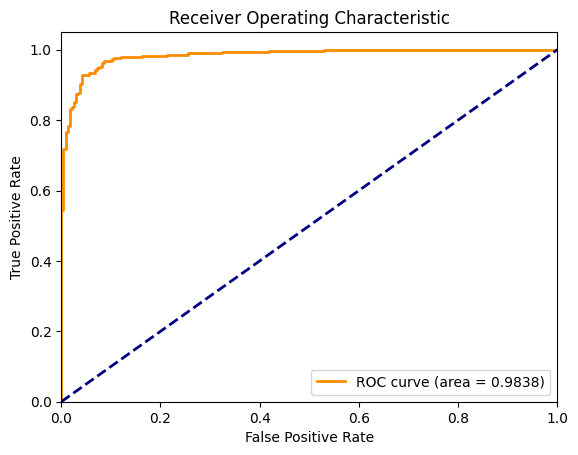

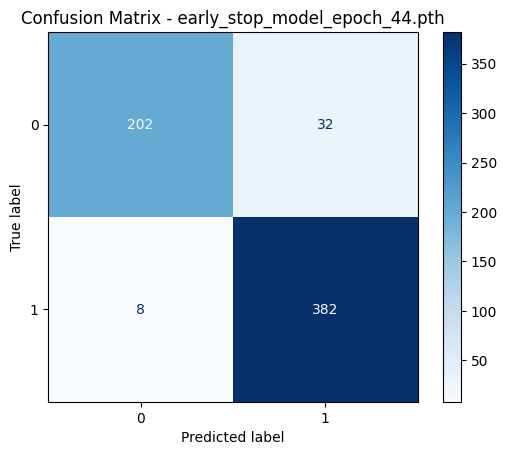

Test done in 0.0 m 5.035024404525757 s 
Test loss: 0.20376, acc: 0.93590, npv: 0.96190, ppv: 0.92271, sen: 0.97949, spe: 0.86325, fos: 0.95025, fpr: 0.13675


In [6]:
import time
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as F

# Evaluation function to calculate accuracy, npv, ppv, etc.
def evaluation(true_labels, pred_labels):
    true_labels = torch.cat(true_labels).cpu().numpy()
    pred_labels = torch.cat(pred_labels).cpu().numpy()

    tp = ((pred_labels == 1) & (true_labels == 1)).sum()
    tn = ((pred_labels == 0) & (true_labels == 0)).sum()
    fp = ((pred_labels == 1) & (true_labels == 0)).sum()
    fn = ((pred_labels == 0) & (true_labels == 1)).sum()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0.0  # Precision
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # Recall
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True negative rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0  # False positive rate
    f1_score = 2 * ppv * sensitivity / (ppv + sensitivity) if (ppv + sensitivity) > 0 else 0.0

    return accuracy, npv, ppv, sensitivity, specificity, f1_score, fpr

# Define the test function
def test(model_name, model_class, test_loader, log_directory, bp=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Set loss function (using CrossEntropyLoss)
    loss_func = torch.nn.CrossEntropyLoss()

    # Load the model and push to device
    model = model_class().to(device)
    model_path = os.path.join(log_directory, model_name)
    model_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(model_dict)

    # Initialize tracking variables
    te_loss, te_loss_b, te_in = 0, 0, 0
    te_tle, te_ple = [], []
    all_probs = []

    print('Model testing started')
    since = time.time()
    model.eval()

    for step, (t_x, t_y) in enumerate(tqdm(test_loader, desc="Testing", unit="batch")):
        t_x, t_y = t_x.to(device), t_y.to(device).squeeze(1)
        te_tle.append(t_y)
        output = model(t_x)

        # Compute loss and probabilities
        loss = loss_func(output, t_y.long())
        probs = torch.softmax(output, dim=1)[:, 1]  # Probability of the positive class
        all_probs.append(probs.detach().cpu().numpy())  # Detach and convert to numpy

        # Determine the predicted labels
        lab = torch.argmax(output, dim=1)
        te_ple.append(lab)
        te_loss_b += loss.item() * t_x.size(0)
        te_in += t_x.size(0)

    # Final calculations
    t_c = time.time() - since
    te_loss = te_loss_b / len(test_loader.dataset)
    te_acc, te_npv, te_ppv, te_sen, te_spe, te_fos, te_fpr = evaluation(te_tle, te_ple)

    # Flatten the list of probabilities and true labels for ROC and confusion matrix
    all_probs = np.concatenate(all_probs)
    true_labels = torch.cat(te_tle).cpu().numpy()

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(true_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve and save
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.savefig("/kaggle/working/roc_curve.png")
    plt.show()

    # Compute confusion matrix
    pred_labels = torch.cat(te_ple).cpu().numpy()
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig("/kaggle/working/confusion_matrix.png")
    plt.show()

    # Print summary metrics
    print(f'Test done in {t_c // 60} m {t_c % 60} s \nTest loss: {te_loss:.5f}, acc: {te_acc:.5f}, '
          f'npv: {te_npv:.5f}, ppv: {te_ppv:.5f}, sen: {te_sen:.5f}, spe: {te_spe:.5f}, fos: {te_fos:.5f}, fpr: {te_fpr:.5f}')

# Example usage:
log_directory = "/kaggle/working"
model_name = "early_stop_model_epoch_37.pth"  # Set your model name here
model_class = EWCAT  # Define your model class here
test_batch_size = 32

# Define your test DataLoader here
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=os.cpu_count())

# Run the test function
# test("best_model_epoch_27.pth", model_class, test_loader, log_directory, bp = False)
def ftest(model_name):
    test(model_name, model_class, test_loader, log_directory, bp = False)
ftest("early_stop_model_epoch_44.pth")

